# Sub-FOV Scan-phase

In [4]:
import masknmf
from pathlib import Path
import fastplotlib as fpl
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

try:
    import mbo_utilities as mbo
except ImportError:
    print("uv pip install git+https://github.com/MillerBrainObservatory/mbo_utilities.git@dev")
    
from scipy.ndimage import fourier_shift
from skimage.registration import phase_cross_correlation

from mbo_utilities import log
from mbo_utilities.phasecorr import _phase_corr_2d

Image(value=b'version https://git-lfs.github.com/spec/...', height='55', width='300')

Valid,Device,Type,Backend,Driver
✅ (default),NVIDIA RTX A4000,DiscreteGPU,Vulkan,560.94
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
❗ limited,Microsoft Basic Render Driver,CPU,D3D12,
❌,NVIDIA RTX A4000/PCIe/SSE2,Unknown,OpenGL,4.6.0 NVIDIA 560.94


## Collect all raw tiffs into a dictionary with: Plane: Data

In [5]:
raw_files = [x for x in Path(r"D:\tests_bigmem\roi2").glob("*.tif*")]
data_store = {}

for file in raw_files:
    if file.stem == "plane11":
        data_store[file.stem] = tifffile.memmap(file)
    
zplane_name = "plane11"
data = data_store[zplane_name]

In [59]:
def phase_offsets_timecourse(data, n_parts=3, upsample=10, max_offset=4, ):
    t, h, w = data.shape
    xsplits = np.linspace(0, w, n_parts + 1, dtype=int)
    offsets = []
    for i in range(n_parts):
        x0, x1 = xsplits[i], xsplits[i + 1]
        patch_offsets = [_phase_corr_2d(frame[:, x0:x1], upsample, max_offset=max_offset,) for frame in data]
        offsets.append(patch_offsets)
    return xsplits, np.array(offsets) 

def plot_phase_offsets(
    mean_img,
    xsplits,
    offsets,
    upsample,
    max_offset,
    title_prefix="",
    save_path=None,
    xmin=None,
    xmax=None,
    share_axis=True,
):
    n_parts, n_frames = offsets.shape
    all_y = np.concatenate(offsets)
    ymin, ymax = all_y.min(), all_y.max()
    pad = 0.05 * (ymax - ymin)
    ymin -= pad
    ymax += pad

    fig_height = 1.5 * (1 if share_axis else n_parts)
    fig = plt.figure(figsize=(10, fig_height), constrained_layout=True)
    outer = GridSpec(1, 2, width_ratios=[1.2, 2], wspace=0.2)

    ax_img = fig.add_subplot(outer[0, 0])
    ax_img.imshow(mean_img, cmap="gray")
    h, w = mean_img.shape
    for i in range(n_parts):
        x0, x1 = xsplits[i], xsplits[i + 1]
        center_x = (x0 + x1) / 2
        rect = plt.Rectangle((x0, 0), x1 - x0, h, edgecolor="red", facecolor="none", linewidth=1.5)
        ax_img.add_patch(rect)
        ax_img.text(center_x, h - 10, f"{i+1}", color='w', fontsize=12, weight="bold", ha="center", va="center")
    ax_img.axis("off")

    if share_axis:
        ax = fig.add_subplot(outer[0, 1])
        for i in range(n_parts):
            y = offsets[i]
            x = np.arange(len(y))
            ax.plot(x, y, lw=0.5, label=f"Part {i+1}")
        ax.axhspan(ymin, ymax, color="0.95", zorder=0)
        ax.set_ylim(ymin, ymax)
        if xmin is not None or xmax is not None:
            ax.set_xlim(left=xmin, right=xmax)
        ax.set_xlabel("Frame", fontsize=10)
        ax.set_ylabel("Offset (px)", fontsize=10)
        ax.spines[:].set_visible(False)
        # ax.tick_params(axis='both', which='both', direction='out')
        ax.legend(loc="best", fontsize=8, frameon=False)
        ax.text(
            0.98, 0.98,
            f"Y-axis: ±{ymax:.1f} px",
            transform=ax.transAxes,
            fontsize=9,
            ha="right",
            va="top",
            color="black",
            fontweight='bold'
        )
    else:
        inner = GridSpecFromSubplotSpec(n_parts, 1, subplot_spec=outer[0, 1], hspace=0.05)
        # label_text = f" Sub-FOVs share Y-axis scale: ± {ymax:.1f} px "
        label_text = ""
        for i in range(n_parts):
            ax = fig.add_subplot(inner[i])
            y = offsets[i]
            x = np.arange(len(y))
            ax.axhspan(ymin, ymax, color="0.95", zorder=0)
            ax.plot(x, y, color="black", lw=0.1, zorder=1)
            if xmin is not None or xmax is not None:
                ax.set_xlim(left=xmin, right=xmax)
            ax.set_ylim(ymin, ymax)
            ax.set_ylabel(f"{i + 1}", fontsize=9, weight="bold", rotation=0, labelpad=15)
            ax.set_yticks([])
            ax.spines[:].set_visible(False)
            # ax.tick_params(axis='y', which='both', left=False, right=False)
            ax.tick_params(axis='x', which='both', bottom=False, labelbottom=(i == n_parts - 1))
            if i == 0:
                if label_text:
                    ax.text(
                        0.88, 1,
                        label_text,
                        transform=ax.transAxes,
                        fontsize=10,
                        ha="right",
                        va="top",
                        color="black",
                        fontweight='bold'
                    )
            if i == n_parts - 1:
                ax.set_xlabel("Frame", fontsize=10)

    if save_path:
        fig.savefig(save_path, dpi=150)

    fig.text(
        0.2, 0.94,
        f"{title_prefix}Per-Frame Offsets (1/{upsample}px) | max shift={max_offset}px",
        fontsize=14, ha="left", fontweight='bold'
    )
    plt.show()

def run_plot_for_plane(
    data,
    plane_name,
    save_dir=None,
    n_parts=None,
    upsample=None,
    max_offset=None,
    xmin=None,
    xmax=None,
    share_axis=False,
):
    mean_img = data.mean(0).astype(np.float32)
    xsplits, offsets = phase_offsets_timecourse(data, n_parts=n_parts, max_offset=max_offset, upsample=upsample,)
    if save_dir:
        Path(save_dir).mkdir(exist_ok=True)
        save_path = Path(save_dir) / f"{plane_name}_offset_plot.png"
    else:
        save_path = None
    plot_phase_offsets(
        mean_img,
        xsplits,
        offsets,
        upsample=upsample,
        max_offset=max_offset,
        title_prefix=f"{plane_name} | ",
        save_path=save_path,
        xmin=xmin, xmax=xmax,
        share_axis=True,
    )

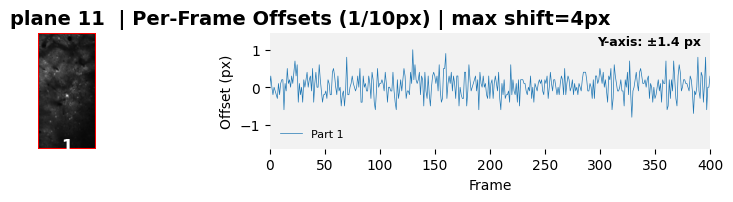

In [77]:
n_parts = 4
upsample = 10
max_offset = 4

run_plot_for_plane(
    data_store["plane11"],
    "plane 11 ",
    save_dir="./results",
    n_parts=1,
    upsample=upsample,
    max_offset=max_offset,
    xmin=0,
    xmax=400,
    share_axis=True
)

In [78]:
# data = data_store['plane11']
# xsplits, offsets = phase_offsets_timecourse(data, n_parts=n_parts, max_offset=max_offset, upsample=upsample,)
xsplits_full, offsets_full = phase_offsets_timecourse(data, n_parts=1, max_offset=max_offset, upsample=upsample,)

In [67]:
xsplits, offsets

(array([  0,  56, 112, 168, 224]),
 array([[-0.2,  0.1, -0.4, ..., -0.2, -0.3, -0.3],
        [-0.2, -0.5,  0. , ..., -0.2, -0.2, -0.4],
        [ 0.1,  0. ,  0. , ..., -0.1, -0.5, -0.4],
        [-0.4,  0.8,  0.9, ...,  0.6,  0.8,  0.1]], shape=(4, 5632)))

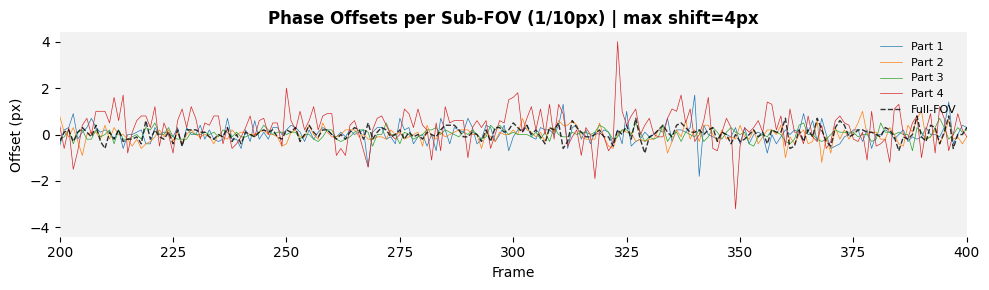

In [85]:
import matplotlib.pyplot as plt
import numpy as np
def plot_offsets_shared_axis(
    offsets,
    xsplits,
    upsample=10,
    max_offset=4,
    xmin=None,
    xmax=None,
    full_fov_offsets=None,
    title="Phase Offsets per Sub-FOV"
):
    n_parts, n_frames = offsets.shape
    x = np.arange(n_frames)

    all_y = offsets.ravel()
    ymin, ymax = all_y.min(), all_y.max()
    pad = 0.05 * (ymax - ymin)
    ymin -= pad
    ymax += pad

    fig, ax = plt.subplots(figsize=(10, 3))
    for i in range(n_parts):
        ax.plot(x, offsets[i], label=f"Part {i+1}", lw=0.5)

    if full_fov_offsets is not None:
        ax.plot(x, full_fov_offsets[0], "--", color="black", label="Full-FOV", lw=1.0, alpha=0.8)

    ax.axhspan(ymin, ymax, color="0.95", zorder=0)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin or 0, xmax or n_frames)
    ax.set_xlabel("Frame", fontsize=10)
    ax.set_ylabel("Offset (px)", fontsize=10)
    ax.spines[:].set_visible(False)
    ax.tick_params(direction='out')
    ax.legend(loc="upper right", fontsize=8, frameon=False)
    ax.set_title(f"{title} (1/{upsample}px) | max shift={max_offset}px", fontsize=12, weight='bold')
    plt.tight_layout()
    plt.show()
    
plot_offsets_shared_axis(offsets, xsplits, upsample=10, max_offset=4, xmin=200, xmax=400, full_fov_offsets=offsets_full)

Initializing MBO Scan with parameters:
roi: None, fix_phase: True, phasecorr_method: frame, border: 3, upsample: 1, max_offset: 4


Raw tiff fully read.


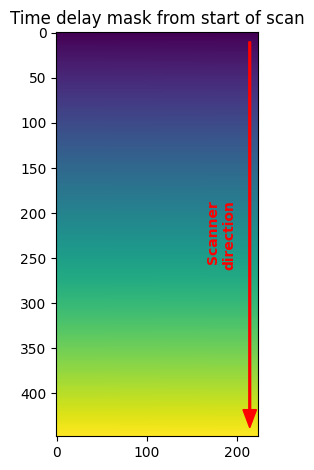

In [167]:
scan = mbo.lazy_array.LazyArrayLoader(r"D:\W2_DATA\kbarber\2025_03_01\mk301\green").load()
delay_img = scan.fields[0].offsets[1]
h, w = delay_img.shape

plt.imshow(delay_img, cmap="viridis")
plt.title("Time delay mask from start of scan")

plt.arrow(
    w - 10, 10,  
    0, h - 20,
    width=2,
    head_width=15,
    head_length=20,
    length_includes_head=True,
    color="red"
)

plt.text(
    w - 25, h // 2,
    "Scanner\ndirection",
    color="red",
    fontsize=10,
    ha="right",
    va="center",
    weight="bold",
    rotation=90
)

plt.tight_layout()
plt.show()

In [ ]:
xsplits, offsets = compute_phase_offsets(data_store["plane11"], n_parts=4, upsample=10, max_offset=3)
corrected = apply_scan_phase_offsets_xsplit(data, xsplits, offsets, upsample=10)
tifffile.imwrite(r"D:\tests_plane11\roi2\interp1\plane11_interp_4strips.tif", corrected)